# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier

In [3]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.inspection import permutation_importance

In [4]:
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import shap

# Read in data

In [6]:
df = pd.read_csv("../DATA/clean.csv")

# TTS

In [7]:
X, X_test, y, y_test = train_test_split(df.drop('class',axis=1),
                                        df['class'],test_size =.1,
                                       random_state=42)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=.09,
                                                 random_state=42)

# Baseline

In [9]:
baseline = y_train.value_counts(normalize=True).max()

# Random Forest

In [10]:
forest = make_pipeline(OneHotEncoder(use_cat_names=True),
                      RandomForestClassifier(n_jobs=-1,random_state=42))

In [11]:
forest.fit(X_train,y_train);

# Metrics

In [12]:
print(f"Baseline: {baseline}\n")
print(f"Train Score: {forest.score(X_train,y_train)}")
print(f"Val score: {forest.score(X_val,y_val)}")
print(f"Test Score: {forest.score(X_test,y_test)}")

Baseline: 0.43687834736036724

Train Score: 0.9628921193573068
Val score: 0.6705314009661836
Test Score: 0.66327329678935


Clearly overfit

# Classification report + Matrix

In [13]:
print(classification_report(y_val, forest.predict(X_val)))

              precision    recall  f1-score   support

         Bad       0.79      0.89      0.84       431
          OK       0.50      0.48      0.49       209
Questionable       0.49      0.33      0.40       198
 Really good       0.68      0.73      0.70       197

    accuracy                           0.67      1035
   macro avg       0.61      0.61      0.61      1035
weighted avg       0.65      0.67      0.66      1035



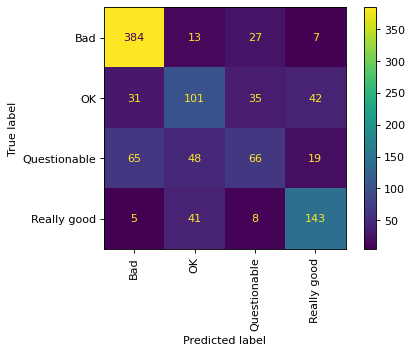

In [17]:
plt.rcParams['figure.dpi'] = 80
plot_confusion_matrix(forest, X_val, y_val, values_format='.0f', xticks_rotation='vertical')

# Permutation Importance

In [18]:
result = permutation_importance(forest, X_val, y_val, 
                                n_repeats=5, random_state=42)

feat_imp = pd.DataFrame({'feature': X_val.columns,
                   'importances_mean': np.round(result['importances_mean'], 3),
                   'importances_std': result['importances_std']})

feat_imp.sort_values(by='importances_mean', ascending=False)

,feature,importances_mean,importances_std
4,rating,0.109,0.007399
1,source,0.095,0.005580
6,num_related,0.062,0.005452
3,duration,0.060,0.005880
0,type,0.024,0.005098
2,episodes,0.020,0.005127
13,comedy,0.018,0.005513
5,studio,0.016,0.002691
7,hentai/romance,0.014,0.004597
12,fantasy/sci-fi,0.007,0.006621


# Feature Importance

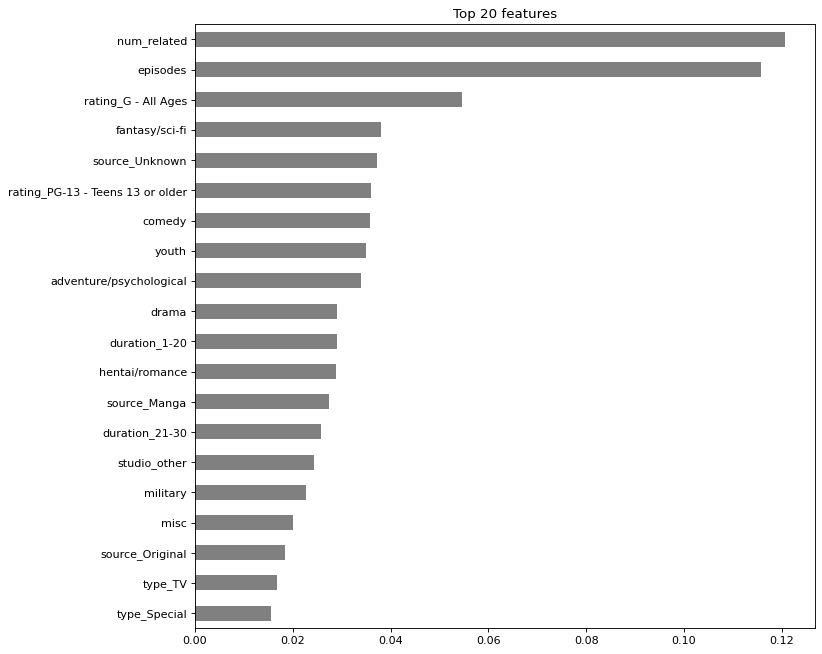

In [22]:
# Get feature importances
encoder = OneHotEncoder(use_cat_names=True)
data_encoded = encoder.fit_transform(X_train)
rf = forest.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, data_encoded.columns)

# Plot feature importances
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

# Hyperparameter Tuning

In [28]:
n_estimators = range(100,2001,100)
criterion = ['gini','entropy']
max_features = ["auto", "sqrt", "log2"]
max_depth = [10,20,30,40,50,60,70,80,90,100,110,"None"]
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]
bootstrap = [True,False]

params = {
    'randomforestclassifier__n_estimators':n_estimators,
    'randomforestclassifier__criterion':criterion,
    'randomforestclassifier__max_features':max_features,
    'randomforestclassifier__max_depth':max_depth,
    'randomforestclassifier__min_samples_split':min_samples_split,
    'randomforestclassifier__min_samples_leaf':min_samples_leaf,
    'randomforestclassifier__bootstrap':bootstrap
}

In [30]:
random_search = RandomizedSearchCV(
    estimator=forest,
    param_distributions=params,
    n_iter = 200,
    verbose=1,
    n_jobs=-1
)

In [31]:
#random_search.fit(X_train,y_train);

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.5min finished


RandomizedSearchCV(estimator=Pipeline(steps=[('onehotencoder',
                                              OneHotEncoder(cols=['type',
                                                                  'source',
                                                                  'duration',
                                                                  'rating',
                                                                  'studio'],
                                                            use_cat_names=True)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'randomforestclassifier__bootstrap': [True,
                                                                              False],
                    

In [34]:
#random_search.best_params_

{'randomforestclassifier__n_estimators': 300,
 'randomforestclassifier__min_samples_split': 10,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__max_features': 'log2',
 'randomforestclassifier__max_depth': 20,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__bootstrap': False}

In [35]:
#random_search.best_score_

0.6552211380284987

# New model

In [36]:
hyper_forest = make_pipeline(OneHotEncoder(use_cat_names=True),
                      RandomForestClassifier(n_jobs=-1,random_state=42,
                                            n_estimators=300,min_samples_split=10,
                                            min_samples_leaf=1,max_features='log2',
                                            max_depth=20,criterion='gini',
                                            bootstrap=False))

In [37]:
hyper_forest.fit(X_train,y_train);

In [39]:
print(f"Basline: {baseline}\n")
print(f"Base model train score: {forest.score(X_train,y_train)}")
print(f"Tuned train score: {hyper_forest.score(X_train,y_train)}\n")
print(f"Base model val score: {forest.score(X_val,y_val)}")
print(f"Tuned val score: {hyper_forest.score(X_val,y_val)}\n")
print(f"Base model test score: {forest.score(X_test,y_test)}")
print(f"Tuned test score: {hyper_forest.score(X_test,y_test)}")

Basline: 0.43687834736036724

Base model train score: 0.9628921193573068
Tuned train score: 0.883416220351951

Base model val score: 0.6705314009661836
Tuned val score: 0.6830917874396135

Base model test score: 0.66327329678935
Tuned test score: 0.6742364917776038


# Saving model

In [40]:
import pickle

In [41]:
with open('tuned_forest',"wb") as myfile:
    pickle.dump(hyper_forest,myfile)